# Interpreting Identity

# Setup
(No need to read)

In [2]:
TRAIN_MODEL = True

In [3]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    ipython.magic("pip install ipympl")
    ipython.magic("pip install scipy")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis
    %pip install ipympl

Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_71479/1878011034.py:22: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_71479/1878011034.py:23: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")
/tmp/ipykernel_71479/1878011034.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("pip install ipympl")


Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_71479/1878011034.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("pip install scipy")


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [5]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [6]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [7]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

Plotting helper functions:

In [8]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [9]:
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/identity.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

# Model Training

## Config

In [10]:
p = 3
frac_train = 1

# Optimizer config
lr = 1e-3
wd = 1e-2
betas = (0.9, 0.999)

num_epochs = 10000
checkpoint_every = 200

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|=|

In [11]:
a_vector = torch.arange(p)
equals_vector = einops.repeat(torch.tensor(p), " -> i", i=p)


In [12]:
dataset = torch.stack([a_vector, equals_vector], dim=1).to(device)
print(dataset)
print(dataset.shape)

tensor([[0, 3],
        [1, 3],
        [2, 3]], device='cuda:0')
torch.Size([3, 2])


In [13]:
labels = dataset[:, 0]
print(labels.shape)
print(labels)

torch.Size([3])
tensor([0, 1, 2], device='cuda:0')


Convert this to a train + test set - 30% in the training set

In [14]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p)
cutoff = int(p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data)
print(train_labels)
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[2, 3],
        [0, 3],
        [1, 3]], device='cuda:0')
tensor([2, 0, 1], device='cuda:0')
torch.Size([3, 2])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)
torch.Size([0, 2])


## Define Model

In [15]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 1,
    d_model = 2,
    d_head = 2,
    d_mlp = 0,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+1,
    d_vocab_out=p,
    n_ctx=2,
    init_weights=True,
    device=device,
    seed = 998,
)
model = HookedTransformer(cfg)
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

## Define Optimizer + Loss

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)
print("Uniform loss:")
print(np.log(p))

tensor(1.3066, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Uniform loss:
1.0986122886681098


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [17]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())

        optimizer.step()
        optimizer.zero_grad()

        with torch.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 199 Train Loss 0.9052673020114971 Test Loss nan
Epoch 399 Train Loss 0.525042449619556 Test Loss nan
Epoch 599 Train Loss 0.47457566271313845 Test Loss nan
Epoch 799 Train Loss 0.4661095110645048 Test Loss nan
Epoch 999 Train Loss 0.46072601913450584 Test Loss nan
Epoch 1199 Train Loss 0.38150069952592214 Test Loss nan
Epoch 1399 Train Loss 0.02621813430405114 Test Loss nan
Epoch 1599 Train Loss 0.007260354815771071 Test Loss nan
Epoch 1799 Train Loss 0.0037368514591406173 Test Loss nan
Epoch 1999 Train Loss 0.002345327898032824 Test Loss nan
Epoch 2199 Train Loss 0.0016277405738320096 Test Loss nan
Epoch 2399 Train Loss 0.001201072411359195 Test Loss nan
Epoch 2599 Train Loss 0.0009236160835354942 Test Loss nan
Epoch 2799 Train Loss 0.0007315351308798009 Test Loss nan
Epoch 2999 Train Loss 0.0005923160581268931 Test Loss nan
Epoch 3199 Train Loss 0.0004878552379977818 Test Loss nan
Epoch 3399 Train Loss 0.00040726960978468697 Test Loss nan
Epoch 3599 Train Loss 0.000343677525546

In [18]:
if TRAIN_MODEL:
    torch.save(
        {
            "model":model.state_dict(),
            "config": model.cfg,
            "checkpoints": model_checkpoints,
            "checkpoint_epochs": checkpoint_epochs,
            "test_losses": test_losses,
            "train_losses": train_losses,
            "train_indices": train_indices,
            "test_indices": test_indices,
        },
        PTH_LOCATION)

In [19]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

# Look at weights

## Embedding weights

In [20]:
from scipy.linalg import qr

print(model.embed.W_E.data)
print(model.embed.W_E.data.shape)

W_E = model.embed.W_E.data.cpu().numpy()
pos = model.W_E_pos.data.cpu().numpy()
for i in range(W_E.shape[0]):
    print(f"Norm of token {i}: {np.linalg.norm(W_E[i])}")
    index = (4 if i < 3 else 5)
    print(f"Embedding: {pos[index]}")
    W_E[i] += pos[index]


# Create a matrix with tensor[0] as the first column
ttr = W_E.transpose()
print(ttr)

# Perform QR decomposition to obtain an orthonormal matrix
Q, R = qr(ttr)

print("Q: ", Q)
print("R: ", R)
print(np.matmul(Q, R))

def get_angle(a, b):
    return np.arccos(
        np.dot(a, b)
        / (np.linalg.norm(a) * np.linalg.norm(b))
    ) / np.pi * 180

dot_product = np.dot(W_E[0], W_E[3])
print(dot_product, get_angle(W_E[0], W_E[3]))
product2 = np.dot(R[:, 0], R[:, 3])
print(product2, get_angle(R[:, 0], R[:, 3]))

tensor([[ 1.3611, -0.9969],
        [-2.3174,  0.4787],
        [ 0.6478,  2.4336],
        [-0.6221, -0.7089]], device='cuda:0')
torch.Size([4, 2])
Norm of token 0: 1.6870782375335693
Embedding: [-1.1621029   0.22185603]
Norm of token 1: 2.366306781768799
Embedding: [-1.1621029   0.22185603]
Norm of token 2: 2.5182929039001465
Embedding: [-1.1621029   0.22185603]
Norm of token 3: 0.9431936144828796
Embedding: [-0.18239078 -1.0527111 ]
[[ 0.19895792 -3.4794922  -0.51431876 -0.8044901 ]
 [-0.77501214  0.70051515  2.655408   -1.7616587 ]]
Q:  [[-0.24865317  0.96859264]
 [ 0.96859264  0.24865305]]
R:  [[-0.80014247  1.5437007   2.6998956  -1.5062907 ]
 [ 0.         -3.1960254   0.16210985 -1.217265  ]]
[[ 0.19895796 -3.4794927  -0.5143192  -0.8044899 ]
 [-0.77501214  0.7005156   2.6554081  -1.7616588 ]]
1.2052472 38.94240893019232
1.2052472 38.94240210000316


U= [[-0.9508836 -0.3095486]
 [-0.3095486  0.9508836]] 
S= [2.8302078e+00 8.6767779e-04] 
V= [[-0.8654889  0.5009281]
 [ 0.5009281  0.8654889]]
U= [[-0.9508836 -0.3095486]
 [-0.3095486  0.9508836]] 
S= [2.8302078e+00 8.6767779e-04] 
V= [[-0.8654889  0.5009281]
 [ 0.5009281  0.8654889]]


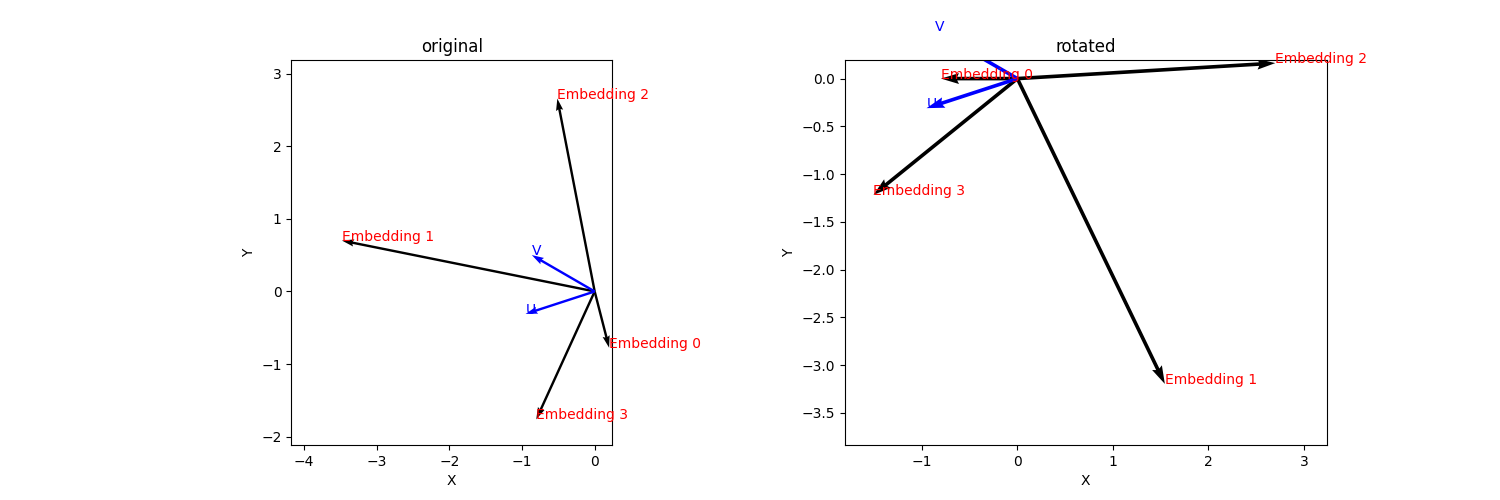

In [21]:
import matplotlib.pyplot as plt
import numpy as n

%matplotlib widget

plt.close('all')

def plot_tensor(fig, tensor, position = 111, title = ""):
    ax = fig.add_subplot(position)
    ax.set_title(title)

    # Define the origin
    origin = np.zeros((4, 2))

    # Plot the arrows
    for i in range(tensor.shape[0]):
        ax.quiver(origin[i, 0], origin[i, 1], 
                tensor[i, 0], tensor[i, 1],
                angles='xy', scale_units='xy', scale=1)

        ax.text(tensor[i, 0], tensor[i, 1], f"Embedding {i}", color='red')
    W_Q = model.blocks[0].attn.W_Q.data[0]
    W_K = model.blocks[0].attn.W_K.data[0].transpose(0, 1)
    W_QK = torch.matmul(W_Q, W_K)
    U, S, V = np.linalg.svd(W_QK.cpu())
    print("U=", U, "\nS=", S, "\nV=", V)
    
    ax.quiver(origin[i, 0], origin[i, 1], U[0, 0], U[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(U[0, 0], U[0, 1], f"U", color='blue')
    ax.quiver(origin[i, 0], origin[i, 1], V[0, 0], V[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(V[0, 0], V[0, 1], f"V", color='blue')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min(tensor[:, 0].min(), 0)*1.2, max(tensor[:, 0].max(), 0) * 1.2)
    ax.set_aspect('equal')
    ax.set_ylim(min(tensor[:, 1].min(), 0)*1.2, max(tensor[:, 1].max(), 0) * 1.2)

fig = plt.figure(figsize=(15, 5))
plot_tensor(fig, W_E, 121, "original")
plot_tensor(fig, R.transpose(), 122, "rotated")
plt.show()

# Unembedding weights

In [22]:
W_U = model.unembed.W_U.data.cpu().numpy()

print(W_U)

Qrev, Rrev = qr(W_U)

print("Q_U=", Qrev)
print("R_U=", Rrev)

print("W_E=", W_E)
print("W_U=", W_U)

product = np.matmul(W_E, W_U)
print(product)

rank = np.linalg.matrix_rank(product)
print(rank)

[[-1.2225037   0.9429486   0.02881091]
 [-0.8431214  -0.28984824  1.5076672 ]]
Q_U= [[-0.82320786 -0.56773996]
 [-0.56773996  0.823208  ]]
R_U= [[ 1.4850485 -0.6116842 -0.8796803]
 [ 0.        -0.773955   1.2247665]]
W_E= [[ 0.19895792 -0.77501214]
 [-3.4794922   0.70051515]
 [-0.51431876  2.655408  ]
 [-0.8044901  -1.7616587 ]]
W_U= [[-1.2225037   0.9429486   0.02881091]
 [-0.8431214  -0.28984824  1.5076672 ]]
[[ 0.41020256  0.412243   -1.1627282 ]
 [ 3.6630728  -3.4840252   0.95589644]
 [-1.6100748  -1.2546414   3.9886534 ]
 [ 2.4687843  -0.2479791  -2.679173  ]]
2


# Activations

In [23]:
input = torch.tensor([[0,3], [1,3], [2,3]])
logits, cache = model.run_with_cache(input)
print(logits)

tensor([[[  5.6979,  -0.5543,  -6.2120],
         [ 11.8204,  -0.2724, -14.2755]],

        [[ -4.1265,   4.0203,  -1.2280],
         [ -5.3191,   7.2557,  -4.8642]],

        [[-19.5746,   1.7208,  21.6311],
         [-15.3279,   2.7120,  14.7788]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [24]:
print(logits)

tensor([[[  5.6979,  -0.5543,  -6.2120],
         [ 11.8204,  -0.2724, -14.2755]],

        [[ -4.1265,   4.0203,  -1.2280],
         [ -5.3191,   7.2557,  -4.8642]],

        [[-19.5746,   1.7208,  21.6311],
         [-15.3279,   2.7120,  14.7788]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [25]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']

In [26]:
cache.cache_dict['hook_embed']

tensor([[[ 1.3611, -0.9969],
         [-0.6221, -0.7089]],

        [[-2.3174,  0.4787],
         [-0.6221, -0.7089]],

        [[ 0.6478,  2.4336],
         [-0.6221, -0.7089]]], device='cuda:0')

In [27]:
W_K = model.blocks[0].attn.W_K.data[0].cpu()
W_Q = model.blocks[0].attn.W_Q.data[0].cpu()
print("W_K: ", W_K)
W_K_T = torch.transpose(W_K, 0, 1)
W_QK = torch.matmul(W_Q, W_K_T)
print("W_Q: ", W_Q)
print("W_K transposed: ", W_K_T)
print(W_QK)
W_V = model.blocks[0].attn.W_V.data[0].cpu()
W_O = model.blocks[0].attn.W_O.data[0].cpu()
W_VO = torch.matmul(W_V, W_O)
print(W_VO)
W_E = model.embed.W_E.data.cpu().numpy()
U, S, V = np.linalg.svd(W_QK)
print("U: ", U)
print("S: ", S)
print("V: ", V)
S_rank_1 = np.zeros((2, 2))
S_rank_1[0, 0] = S[0]
print("S_rank_1: ", S_rank_1)
W_QK_rank_1 = np.matmul(np.matmul(U, S_rank_1), V)
print("W_QK_rank_1: ", W_QK_rank_1)

W_K:  tensor([[ 0.5955, -1.1648],
        [-0.3195,  0.7005]])
W_Q:  tensor([[ 1.3553, -1.3067],
        [ 0.4687, -0.4117]])
W_K transposed:  tensor([[ 0.5955, -0.3195],
        [-1.1648,  0.7005]])
tensor([[ 2.3291, -1.3483],
        [ 0.7587, -0.4381]])
tensor([[-1.7041,  1.3890],
        [ 2.1980,  4.6275]])
U:  [[-0.9508836 -0.3095486]
 [-0.3095486  0.9508836]]
S:  [2.8302078e+00 8.6767779e-04]
V:  [[-0.8654889  0.5009281]
 [ 0.5009281  0.8654889]]
S_rank_1:  [[2.83020782 0.        ]
 [0.         0.        ]]
W_QK_rank_1:  [[ 2.3292022  -1.34809685]
 [ 0.75824342 -0.43885652]]


In [28]:
cache.cache_dict

{'hook_embed': tensor([[[ 1.3611, -0.9969],
          [-0.6221, -0.7089]],
 
         [[-2.3174,  0.4787],
          [-0.6221, -0.7089]],
 
         [[ 0.6478,  2.4336],
          [-0.6221, -0.7089]]], device='cuda:0'),
 'hook_pos_embed': tensor([[[-1.1621,  0.2219],
          [-0.1824, -1.0527]],
 
         [[-1.1621,  0.2219],
          [-0.1824, -1.0527]],
 
         [[-1.1621,  0.2219],
          [-0.1824, -1.0527]]], device='cuda:0'),
 'blocks.0.hook_resid_pre': tensor([[[ 0.1990, -0.7750],
          [-0.8045, -1.7617]],
 
         [[-3.4795,  0.7005],
          [-0.8045, -1.7617]],
 
         [[-0.5143,  2.6554],
          [-0.8045, -1.7617]]], device='cuda:0'),
 'blocks.0.attn.hook_q': tensor([[[[-0.0936,  0.0591]],
 
          [[-1.9161,  1.7764]]],
 
 
         [[[-4.3873,  4.2582]],
 
          [[-1.9161,  1.7764]]],
 
 
         [[[ 0.5477, -0.4211]],
 
          [[-1.9161,  1.7764]]]], device='cuda:0'),
 'blocks.0.attn.hook_k': tensor([[[[ 0.3661, -0.7747]],
 
          [[ 